# Dataset
This ipynb file generates information for the rest of the document. By importing `astroquery`, after being given a set of ICRS coordinates, the library returns useful information such as its ID, Flux(B), Flux(U), etc,--which will all be saved in `StarList`. The code grabs all information from `Images/(SP_TYPE).txt`, which totals to 7000 random stars generated by simbad through `sptype`. Using the flux values, the code compares the calculated flux with the given flux by using BV_index, UB_index, and so on, outputting a percentage of each score and graphed using bar and pie in `matplotlib`.

Pip install the following libraries (will be used for coordinate conversion, astronomy data, plotting, etc.):

In [3]:
#pip install the following libraries:
import numpy as np 
import os 
import matplotlib.pyplot as plt
#pip install pandas
import pandas as pd
#Create Info-table based on available data
#pip install astroquery
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
from scipy.optimize import curve_fit
from scipy.stats import chisquare

IMGDATASET_PATH, folder_path, count_path = os.path.join('Dataset', 'Dataset.csv'), os.path.join('Images'), 'Count.csv' #Sets up path to specific items using os.path.join for usage on both Linux and Windows
A, B, F, G, K, M, O = 'A', 'B', 'F', 'G', 'K', 'M', 'O' #Sets up the Spectral Types

COUNT_PATH = os.path.join(folder_path, count_path) #Sets up path to Count.csv using os.path.join

Updating the CSV File with the total counts in Dataset:

In [ ]:
def update_csv():
    Count = pd.read_csv(COUNT_PATH, index_col=0) #Reads CSV file and loads with pandas -> path set above
    DSet = pd.read_csv(IMGDATASET_PATH, index_col=0)

    for class_dir in (A, B, F, G, K, M, O):
        num_items = len(DSet[DSet['Spectral Class'] == class_dir]) #Checks the number of files in the Dataset class folders, lists these as the number of items in each class. 

        Count[class_dir][0] = num_items #Updates the pandas Dataframe to reflect the updated number of files in the Dataset

    Count.to_csv(COUNT_PATH) #Saves dataset

update_csv()

### Generated Data Completion
This codes write to `GeneratedData.txt` for every 7000 stars and for every star contains their numerical number and ["ID","Spectral Class","Ra","Dec","flux(U)","flux(B)","flux(V)", "flux(R)", "flux(I)","flux(G)","flux(J)","flux(H)","flux(K)"]. The function `parse` takes a raw coordinate from a spectral type txt under images and adds the colon inside to pass it on to `get_simbad_data`. That function takes the coordinate and spectral type and converts to pass on to `astoquery` which returns a `result_table`. From that, we use indices to obtain all necessary information which we add to `StarList`. Then it writes all 7000 stars to the `GeneratedData.txt`. On initial runthrough, there will be no cache and therefore the code will run quicker with subsequent executions with initial commit 7000 stars and more than a second for each star with subsequent executions being almost instantaneous. There are no other ways to speed up this code. **PLEASE DO NOT RUN THE BELOW CODE, AS IT WILL TAKE A WHILE TO DOWNLOAD THE INFORMATION FOR 7000 STARS AND SHUFFLE THE DATASET.** Furthermore, if you do run this, this will fail multiple times due to Simbad timing people out after a number of internet requests over a short period of time. If this happens, just rerun the cell below. Simbad will cache data, so it should run much faster. If you don't want to wait, you can get GeneratedData.txt and place it in the Images folder from the ZIP file.

In [ ]:
valid_response = False 
while not valid_response:
    response = input('Do you really want to run this block of code? This will BREAK THE IMAGE DATASET (IRREPAIRABLE), AND YOU WILL NEED TO MANUALLY RECREATE THE IMAGE DATASET USING Image Dataset.ipynb BECAUSE IT IS SPECIFICALLY SET UP FOR SHUFFLING!!! Enter (y/n) for yes/no')

    if response.lower() == 'y':
        f = open(os.path.join('Images', 'GeneratedData.txt'), "w")
        StarList=[["ID","Spectral Class","Ra","Dec","flux(U)","flux(B)","flux(V)", "flux(R)", "flux(I)","flux(G)","flux(J)","flux(H)","flux(K)"]]
        #StarList would be eventually appended to contain all (7000) of the stars
        Count=0

        def parse(coord):
            for i,s in enumerate(coord):
                if s == '+' or s=='-':
                    return ":".join(coord[:i].split())+" "+":".join(coord[i:].split()) #Adding colons in between the ICRS coordinate, instead of spaces

        def get_simbad_data(sp, cmd):
            global Count
            Count+=1
            StarList.append([])
            # Convert coordinates to astropy SkyCoord object
            # cmd: Right Ascension and Declination in the format "h:m:s +d:m:s".
            #separate into ra and dec
            ra, dec=cmd.split()
            ra = coord.Angle(ra, unit=u.hourangle)
            dec = coord.Angle(dec, unit=u.deg)
            coords = coord.SkyCoord(ra, dec, frame='icrs') #Setting up the specific coordinates for the star
            
            # Set up Simbad instance, timeout if needed
            custom_simbad = Simbad()
            custom_simbad.add_votable_fields("flux(U)","flux(B)","flux(V)", "flux(R)", "flux(I)","flux(G)","flux(J)","flux(H)","flux(K)")
            result_table = custom_simbad.query_region(coords)  # Change radius if needed
            # print(result_table)

            #FOR EACH OF THE TRY, EXCEPTS, -- represents when the data is NOT PRESENT
            try: 
                StarList[Count].append(str(result_table[0][0]))
            except:
                StarList[Count].append("--") 
            try: 
                StarList[Count].append(sp)
            except:
                StarList[Count].append("--")
            try: 
                StarList[Count].append(str(result_table[0][1]))
            except:
                StarList[Count].append("--")
            try:
                StarList[Count].append(str(result_table[0][2]))
            except:
                StarList[Count].append("--")
            for i in range(11,20):
                try: 
                    StarList[Count].append(str(result_table[0][i]))
                except:
                    StarList[Count].append("--")


        Stars=["O","B","A","F","G","K","M"]

        count=0

        # get_simbad_data("O", "02:22:54.2923 +41:28:47.724")

        for Star in Stars:
            with open(os.path.join('Images', Star+'.txt'), "r") as file:
                # Read and process each line one by one
                for i in range(9):
                    file.readline()
                for line in file:
                    count+=1
                    print(count)
                    # Process the current line (run function above)
                    get_simbad_data(Star,parse(line.split("|")[3]))
                    # get_simbad_data(str(line.strip()))
                file.close()

        Star = pd.DataFrame(StarList) #Turns into Pandas DataFrame for easier saving to txt file
        Star.columns = Star.iloc[0] #Sets the columns of the Pandas Dataframe as first row of the StarList -> this is because StarList was set up that way
        Star = Star[1:] #Removes the first row from the data of the Pandas DataFrame because it is now the column names
        Star.to_csv(os.path.join('Images', 'GeneratedData.txt'), sep=',') #Saves to CSV with os.path.join for Linux AND Windows compatibility
        valid_response = True
    
    elif response.lower() == 'n':
        valid_response = True 
    
    else:
        print('Enter "y" or "n" so that the code can know your intentions!')

### Data Analysis
There are two types of graphs. The first graph is paramerized by bound, which takes the type of color index, indices of the flux, and stellar classification parameters. The numbers are defined by taking the average between bridges of __[Intrinsic colours as a function of spectral type](https://www.stsci.edu/~inr/intrins.html)__ (click for link). 

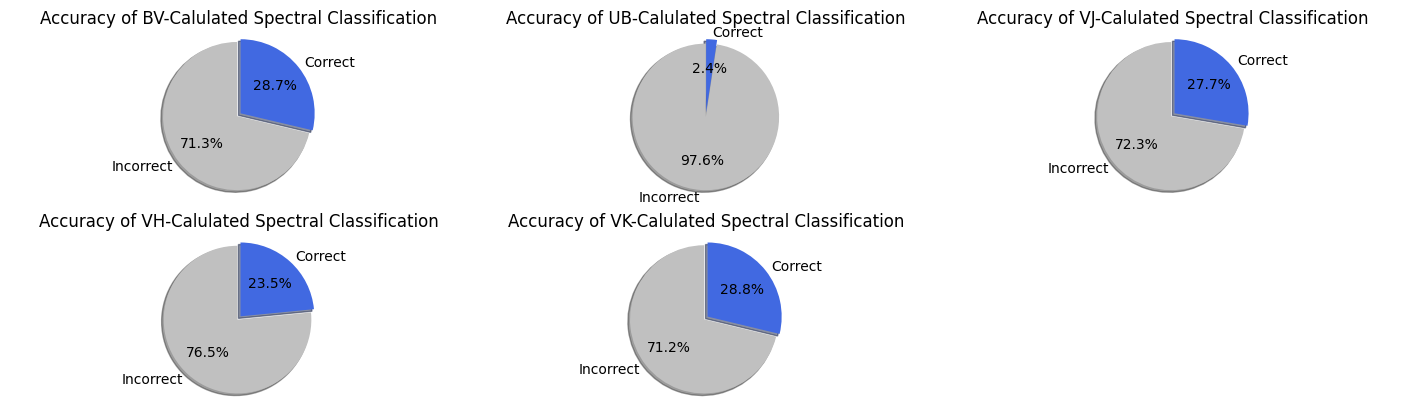

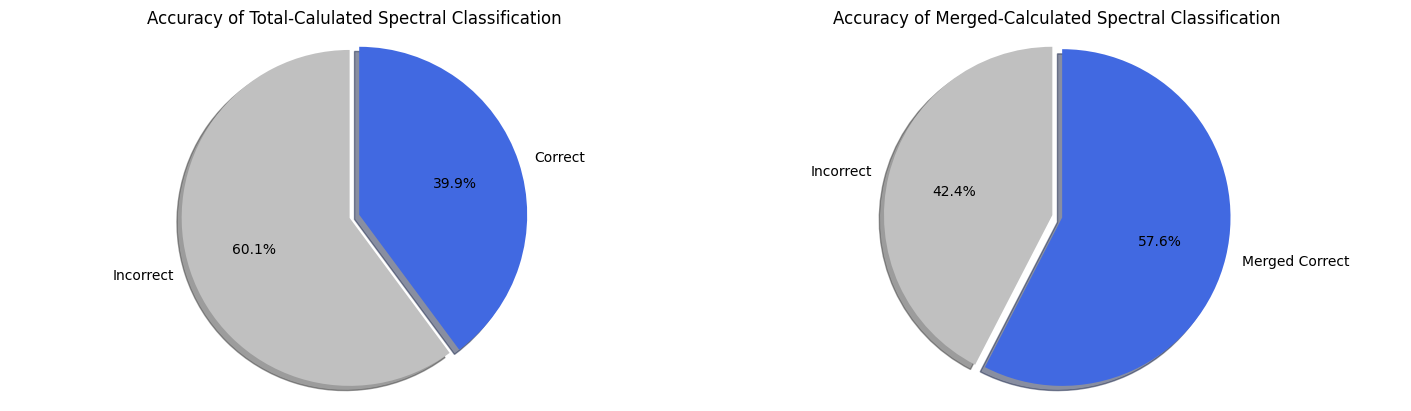

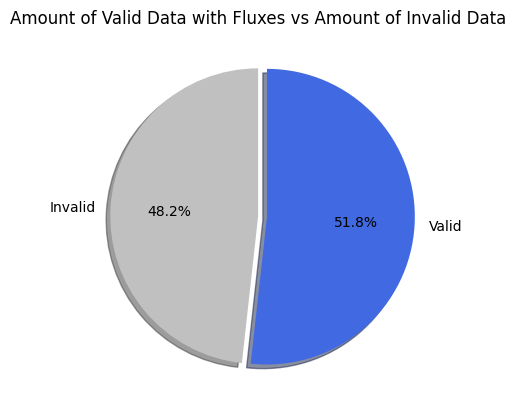

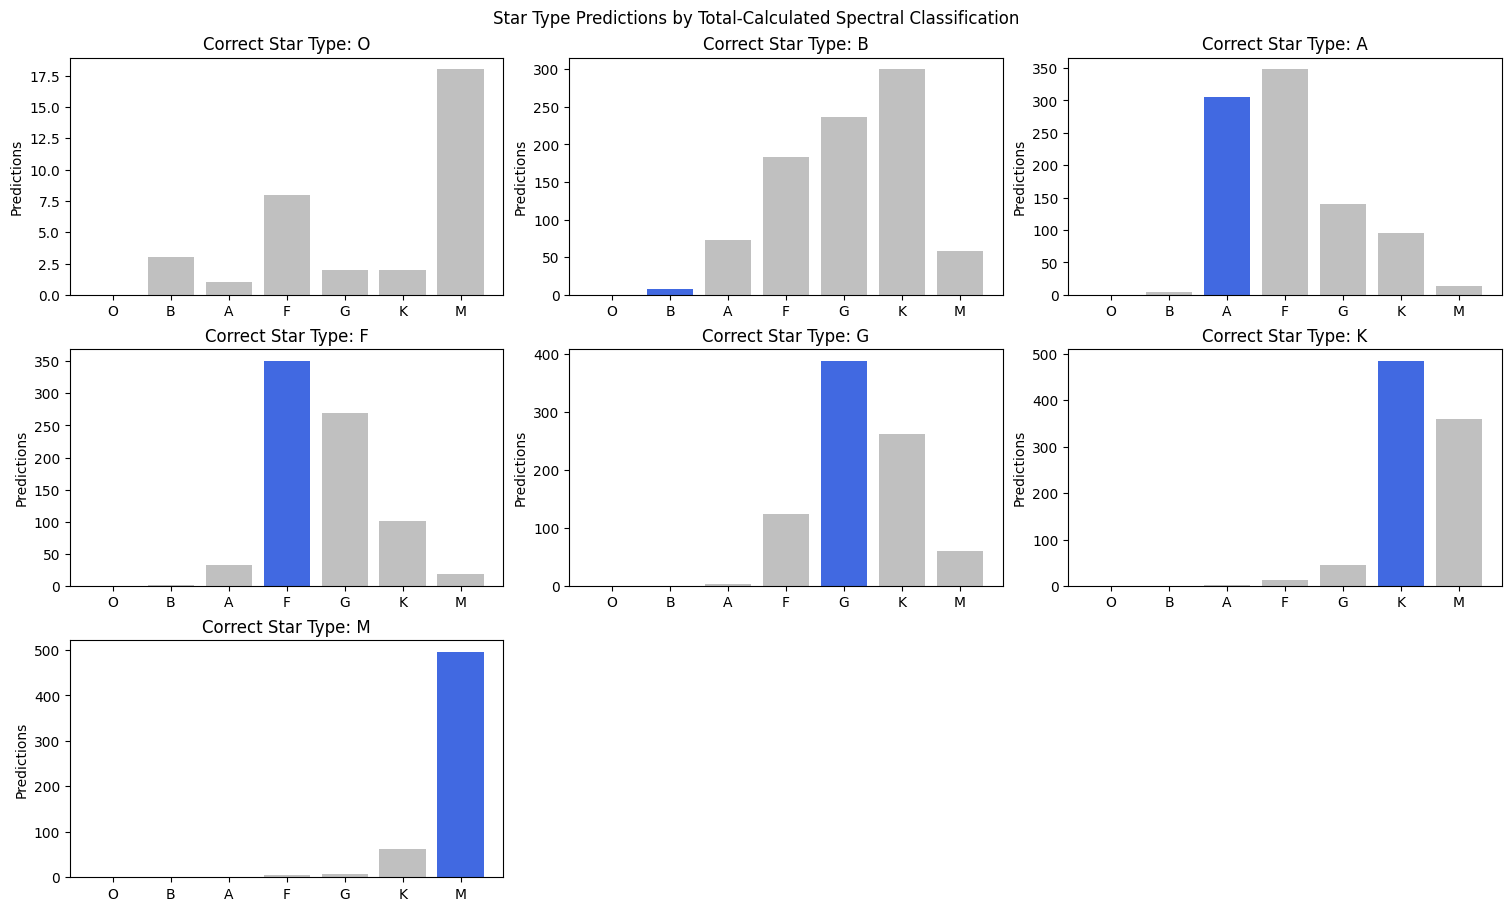

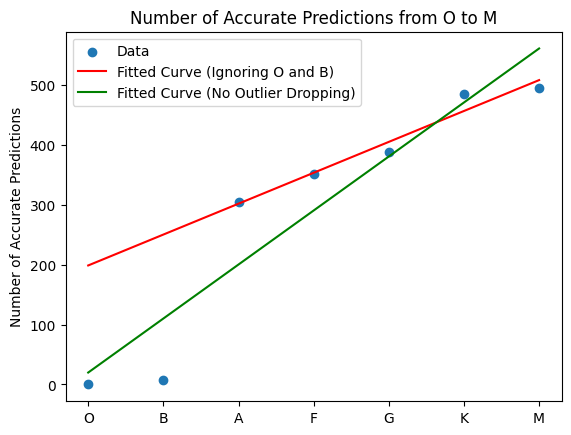

Fitted Line  (Ignoring Outliers): Slope: 51.6000000001104 +- 6.395831972525188 Intercept: 198.80000000043125 +- 27.135216895056192
Fitted Line (No Dropping Outliers): Slope: 90.2142857144803 +- 14.625913598331246 Intercept: 19.928571428612713 +- 52.734482258816335
Chi_Squared (Ignoring Outliers) 0.005891707335487851


In [4]:
#Exexcute only if GeneratedData.txt is valid, returns distribution
StarList = pd.read_csv(os.path.join('Images', 'GeneratedData.txt'), index_col=0).to_numpy() #Takes StarList from the GeneratedData.txt
Specific_Stars = pd.read_csv(os.path.join('Images', 'GeneratedData.txt'), index_col=0)

Ans=[]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 4), layout="constrained") #Sets up subplots
axes = axes.flatten() #Flattens axes for easier access
p=-1
#compare stars for each color indices through bounds
def bound(s,ind1, ind2, a,b,c,d,e,f):
    global p
    count=7000
    ac=0
    t=[]
    for i,Star in enumerate(StarList): #Evaluates using types of manual spectral classification for all star in StarList
        # if i!=0 and Star[1]!='---':
        try:
            BV = float(Star[ind1])-float(Star[ind2])
            if BV < a: spec = "O"
            elif a <= BV < b: spec = "B"
            elif b <= BV < c: spec = "A"
            elif c <= BV < d: spec = "F"
            elif d <= BV < e: spec = "G"
            elif e <= BV < f: spec = "K"
            elif BV >= f : spec = "M"
            else: spec = "N/A"
        #think of BV as other indices
        except:
            spec="N/A"
        t.append(spec)
        if spec==Star[1]: ac+=1
    Ans.append(t)
    p+=1
    axes[p].pie([count-ac,ac], labels=["Incorrect", "Correct"], colors=["Silver","Royalblue"], explode=(0,0.06), autopct='%1.1f%%', startangle=90, shadow=True)
    axes[p].set_title('Accuracy of '+s+'-Calulated Spectral Classification')
    axes[p].axis('equal')

bound("BV", 5,6,-0.30,-0.025,0.31,0.565,0.775,1.35)
bound("UB", 4,5,-1.08,-0.06,0.055,0.04,0.37,1.22)
bound("VJ", 6,10,-0.80,-0.19,0.34,0.83,1.24,2.395)
bound("VH", 6,11,-0.92,-0.24,0.53,1.105,1.555,1.455)
bound("VK", 6,12,-0.97,-0.215,0.48,1.085,1.605,3.15)
fig.delaxes(axes[5])
plt.show()

#choose most probable answer
def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

#list in order
L=['O','B','A','F','G','K','M']

correct=0
correct2=0
inv=0
Ans2=[]
#Ans2 Used for subseuquent graphs, correct used for accuracy
for i in range(7000):
    temp=[]
    counter=0
    for k in range(5):
        temp.append(Ans[k][i])
        if Ans[k][i]=="N/A": counter+=1
    if StarList[i][1]==most_frequent(temp):
        correct+=1
    Ans2.append(most_frequent(temp))
    for k in range(5):
        if Ans[k][i]==StarList[i][1]:
            correct2+=1
            break
    if counter==5: inv+=1

#Total percent correct
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), layout="constrained")
axes = axes.flatten()
axes[0].pie([7000-correct-inv, correct], labels=["Incorrect", "Correct"], colors=["Silver","Royalblue"], explode=(0,0.06), autopct='%1.1f%%', startangle=90, shadow=True)
axes[0].set_title('Accuracy of Total-Calulated Spectral Classification')
axes[0].axis('equal')
axes[1].pie([7000-correct2-inv, correct2], labels=["Incorrect", "Merged Correct"], colors=["Silver","Royalblue"], explode=(0,0.06), autopct='%1.1f%%', startangle=90, shadow=True)
axes[1].set_title('Accuracy of Merged-Calculated Spectral Classification')
axes[1].axis('equal')

#Data Comparision between valid and invalid
plt.show()
plt.title('Amount of Valid Data with Fluxes vs Amount of Invalid Data')
plt.pie([inv, correct], labels=["Invalid", "Valid"], colors=["Silver","Royalblue"], explode=(0,0.06), autopct='%1.1f%%', startangle=90, shadow=True)
plt.show()

#need data for differnet types of stars
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9), layout="constrained")
axes = axes.flatten()
fig.suptitle("Stellar Classification Evaluation")

#initializing dictionary of all types for accuracy
star_type_predictions = {'O': [0,0,0,0,0,0,0],'B': [0,0,0,0,0,0,0],'A': [0,0,0,0,0,0,0],'F': [0,0,0,0,0,0,0],'G': [0,0,0,0,0,0,0],'K': [0,0,0,0,0,0,0],'M': [0,0,0,0,0,0,0]}

for index, row in Specific_Stars.iterrows():
    
    predict = Ans2[index]
    if predict != 'N/A':
        star_type_predictions[row['Spectral Class']][L.index(predict)] += 1

#plot all datasets as a variable for each spectral type
k = 0
for k, (key, predict) in zip(range(7), star_type_predictions.items()):
    colors=["Silver","Silver","Silver","Silver","Silver","Silver","Silver"]
    colors[k]="RoyalBlue"
    axes[k].bar(L,predict,color=colors)
    axes[k].set_title(f'Correct Star Type: {L[k]}')
    axes[k].set(ylabel='Predictions')

#figure parsing
fig.delaxes(axes[7])
fig.delaxes(axes[8])
fig.suptitle('Star Type Predictions by Total-Calculated Spectral Classification')
plt.show()

#best fit line
def linear(x, m, b):
    return m * x + b

xs = list(range(7))

#sp typelist appended, data for plot
star_type_list = []
for spectral_type, star_types_listed in star_type_predictions.items(): 
    star_type_list.append(star_types_listed[L.index(spectral_type)])

# Perform the curve fit
params_ignore, covariance_ignore = curve_fit(linear, xs[2:], star_type_list[2:])
m_fit_ignore, b_fit_ignore = params_ignore
#curve fit for second set
params, covariance = curve_fit(linear, xs, star_type_list)
m_fit, b_fit = params

# Generate the fitted curve
x_fit = np.linspace(min(xs), max(xs), 1000)
y_fit = linear(x_fit, m_fit_ignore, b_fit_ignore)
# Plot the original data and the fitted curve
plt.scatter(xs, star_type_list, label='Data')
plt.plot(x_fit, y_fit, label='Fitted Curve (Ignoring O and B)', color='red')
plt.plot(x_fit, linear(x_fit, m_fit, b_fit), label='Fitted Curve (No Outlier Dropping)', c='g')
plt.xticks(ticks=range(7), labels=('O', 'B', 'A', 'F', 'G', 'K', 'M'))
plt.ylabel('Number of Accurate Predictions')
plt.title('Number of Accurate Predictions from O to M')
plt.legend()
plt.show()

print(f'Fitted Line  (Ignoring Outliers): Slope: {m_fit_ignore} +- {np.sqrt(covariance_ignore[0, 0])}', f'Intercept: {b_fit_ignore} +- {np.sqrt(covariance_ignore[1, 1])}')
print(f'Fitted Line (No Dropping Outliers): Slope: {m_fit} +- {np.sqrt(covariance[0, 0])}', f'Intercept: {b_fit} +- {np.sqrt(covariance[1, 1])}')

chi_square=0
for i in range(2,7):
    temp=star_type_list[i]-linear(xs[i],m_fit_ignore,b_fit_ignore)
    chi_square+=(temp/star_type_list[i])**2
#chi square for all data
print("Chi_Squared (Ignoring Outliers)", chi_square)

### Modules Regarding Dataset Modification

The section of code below initializes an empty dataset AND Count.csv for use.

In [ ]:
#ONLY RUN THIS MODULE IF YOU WANT TO INITIALIZE AN EMPTY DATASET!!! (But it will check whether it exists also)

if not os.path.exists(IMGDATASET_PATH): #Run if a dataset file/folder combo doesn't exist in the user's folder. 
    
    if os.path.exists(os.path.join('Dataset')): #If the folder exists, delete it to remake
        os.rmdir(os.path.join('Dataset'))
    
    os.mkdir(os.path.join('Dataset')) #Make the folder

    with open(os.path.join(IMGDATASET_PATH), 'w') as writing: 
        pass #Make the file "Dataset.csv" and write nothing to it

In [ ]:
#ONLY RUN THIS MODULE IF YOU WANT TO INITIALIZE COUNT.CSV IN THE IMAGES FILE!!!! (But it will check whether it exists also)

if not os.path.exists(COUNT_PATH): #If Count.csv does not exist

    Count_Init = pd.DataFrame(0, index=['Num Items'], columns=(A, B, F, G, K, M, O)) #Initialize DataFrame (Empty, with columns indicating count of items)
    Count_Init.to_csv(COUNT_PATH)
    
    update_csv()

    del(Count_Init)

In [ ]:
if os.path.exists(COUNT_PATH) and os.path.exists(IMGDATASET_PATH): #Checks whether path exists and informs user
    print('Path Can Be Found')

if not os.path.exists(COUNT_PATH): #Informs user that Count.csv does not exist
    print('Check whether the Count.csv file exists in the Images folder')

if not os.path.exists(IMGDATASET_PATH): #Informs user that Dataset folder/file combo does not exist
    print('Check whether the Dataset folder exists.')

The code below SHUFFLES the GeneratedData.txt file because we cannot do that in Model.ipynb for purposes of linking the images with the GeneratedData.txt. **DO NOT RUN THE BELOW CODE, OR IT WILL UNLINK THE SPECIFIC IMAGES WITH THE DATA**

In [ ]:
#SHUFFLE THE GENERATEDDATA.TXT FILE (DO NOT RUN!!!)

valid_response = False 
while not valid_response:
    response = input('Do you really want to run this block of code? This will BREAK THE IMAGE DATASET (IRREPAIRABLE), AND YOU WILL NEED TO MANUALLY RECREATE THE IMAGE DATASET USING Image Dataset.ipynb BECAUSE IT IS SPECIFICALLY SET UP FOR SHUFFLING!!! Enter (y/n) for yes/no')

    if response.lower() == 'y':
        shuffled = pd.read_csv(os.path.join('Images', 'GeneratedData.txt'), index_col=0).sample(frac=1).reset_index(drop=True) #Shuffles the DataFrame using sampling and reseting the index
        shuffled.to_csv(os.path.join('Images', 'GeneratedData.txt'))
        valid_response = True 
    
    elif response.lower() == 'n':
        valid_response = True 

    else: 
        print('Enter "y" or "n" so that the code can know your intentions!')

The below cells are for visualization of the dataset specifications.

In [ ]:
#Run this cell if you want to view specifications for the dataset! (Path will NOT be Checked)

Count = pd.read_csv(COUNT_PATH, index_col=0)
Count.head()

In [ ]:
#Run this cell in addition to the above cell for visualization!
figure, ax1 = plt.subplots(1, 1, layout='constrained')

ax1.bar(list(Count.columns.values), Count.to_numpy()[0], align='center')
ax1.set(title='Number of Images in Dataset', xlabel='Dataset Folder Classification', ylabel='Number of Images')

plt.show()
print(f'Total Number of Images in Dataset: {sum(Count.to_numpy()[0])}')

The below cells update the dataset and view the GeneratedData.txt. 

### DO NOT UPDATE THE DATASET IF YOU HAVE RUN THE CODE (Cells with prompts to them) ABOVE FOR UPDATING GENERATEDDATA.txt!!!

In [ ]:
#Updating the Dataset
valid_response, GEN_PATH = False, os.path.join(folder_path, 'GeneratedData.txt')

while not valid_response: 
    update = input('Do you really want to update the Dataset? If you have run the cells above which update GeneratedData.txt (Cells that ask whether or not you want to run them, this will BREAK THE IMAGE DATASET AND THE REGULAR DATASET!!! (y/n) ?')

    if update.lower() == 'y':

        GeneratedData = pd.read_csv(GEN_PATH, index_col=0) #Reads Generated Data

        NewDataset = GeneratedData[['Spectral Class', 'flux(U)', 'flux(B)', 'flux(V)', 'flux(R)', 'flux(I)', 'flux(G)', 'flux(J)', 'flux(K)']].replace('--', 0) #Replaces '--' with 0 (imputation preparation for the model)

        NewDataset.to_csv(IMGDATASET_PATH) #Saves File
        valid_response = True
    
    elif update.lower() == 'n': 
        valid_response = True 
    
    else: 
        print('You must enter a valid response of "y" or "n", which represents "yes" or "no"!')

In [ ]:
#View Pretty Version of TXT file Generated Data
GeneratedData = pd.read_csv(GEN_PATH, index_col=0) #Reads Generated Data
GeneratedData.head(len(GeneratedData.index))